In [1]:
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
from numpy.random import RandomState
import collections
import io
%matplotlib inline

In [2]:
f=open('CTMC-Qmatrix.csv', 'rU',)
M=np.loadtxt(f,dtype = 'str',delimiter=',')

In [3]:
for i in range(len(M)):
    if '\xe2\x88\x92' in M[i][i]:
        M[i][i] = M[i][i].replace('\xe2\x88\x92','-')
Q = M.astype(np.float)
qi = np.diagonal(Q.copy())

In [46]:
# matrix of rates of transition
print M 

[['-10' '4' '0' '0' '0' '0' '0' '6' '0' '0']
 ['6' '-15' '3' '0' '0' '0' '0' '6' '0' '0']
 ['0' '3' '-15' '6' '0' '0' '0' '0' '0' '6']
 ['0' '0' '5' '-10' '5' '0' '0' '0' '0' '0']
 ['0' '0' '0' '6' '-15' '3' '0' '0' '0' '6']
 ['0' '0' '0' '0' '3' '-15' '6' '0' '6' '0']
 ['0' '0' '0' '0' '0' '4' '-10' '0' '6' '0']
 ['4' '6' '0' '0' '0' '0' '0' '-10' '0' '0']
 ['0' '0' '0' '0' '0' '6' '4' '0' '-10' '0']
 ['0' '0' '5' '0' '5' '0' '0' '0' '0' '-10']]


M is a matrix of derivatives $ \frac{dp_{ij}(t)}{dt} $ . Matrix of transition probabilities can be recovered from it, as $\lambda$ parameter is a rate of probability change with time, and we know that transition probabilities are distributed exponentially. 

However, we don't need that now, as to simulate continious Markov chain we need to know only transition probabilities to other nodes, which remaim stable in relation to each other with time, and node holding time, and node holding time, which can be modelled independently. That way the CTMC is modelled independently as two processes:

1)DTMC, as at any time the relative transition probabilities are stable, and proportional to $\lambda$ parameters, received from matrix M.

2)Exponentially distributed holding time.As time of transition is min($t_1,t_2,..,t_n$) for all possible transitions, it can be shown that holding time is distributed with parameter $\lambda_i = \sum \lambda_{ij}$

Other option is to model the MC directly, as we have $\lambda$ parameters
The main tool for simulation was a direct simulation using exponential distribution for all values, the first approach being less computationally heavy,and more preferable, however

In [45]:
# our DTMC matrix
print Q

[[ 0.   0.4  0.   0.   0.   0.   0.   0.6  0.   0. ]
 [ 0.4  0.   0.2  0.   0.   0.   0.   0.4  0.   0. ]
 [ 0.   0.2  0.   0.4  0.   0.   0.   0.   0.   0.4]
 [ 0.   0.   0.5  0.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.4  0.   0.2  0.   0.   0.   0.4]
 [ 0.   0.   0.   0.   0.2  0.   0.4  0.   0.4  0. ]
 [ 0.   0.   0.   0.   0.   0.4  0.   0.   0.6  0. ]
 [ 0.4  0.6  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.6  0.4  0.   0.   0. ]
 [ 0.   0.   0.5  0.   0.5  0.   0.   0.   0.   0. ]]


In [14]:
np.fill_diagonal(Q, 0)
for i in range(len(Q)):
    Q[i]=Q[i]/sum(Q[i])

In [ ]:
Matr = M.copy()
np.fill_diagonal(Matr,0)
Matr = Matr.astype(int)


In [15]:
G = nx.DiGraph()
ebunch = []
shape = Q.shape
for i in range(shape[0]):
    for j in range(shape[1]):
        if Q[i][j] > 0:
            ebunch.append((i+1,j+1,Q[i][j]))
G.add_weighted_edges_from(ebunch)
labels={}
for i in G.nodes():
    labels[i]=i

printing the discreet graph with transition probabilities (closer to node)

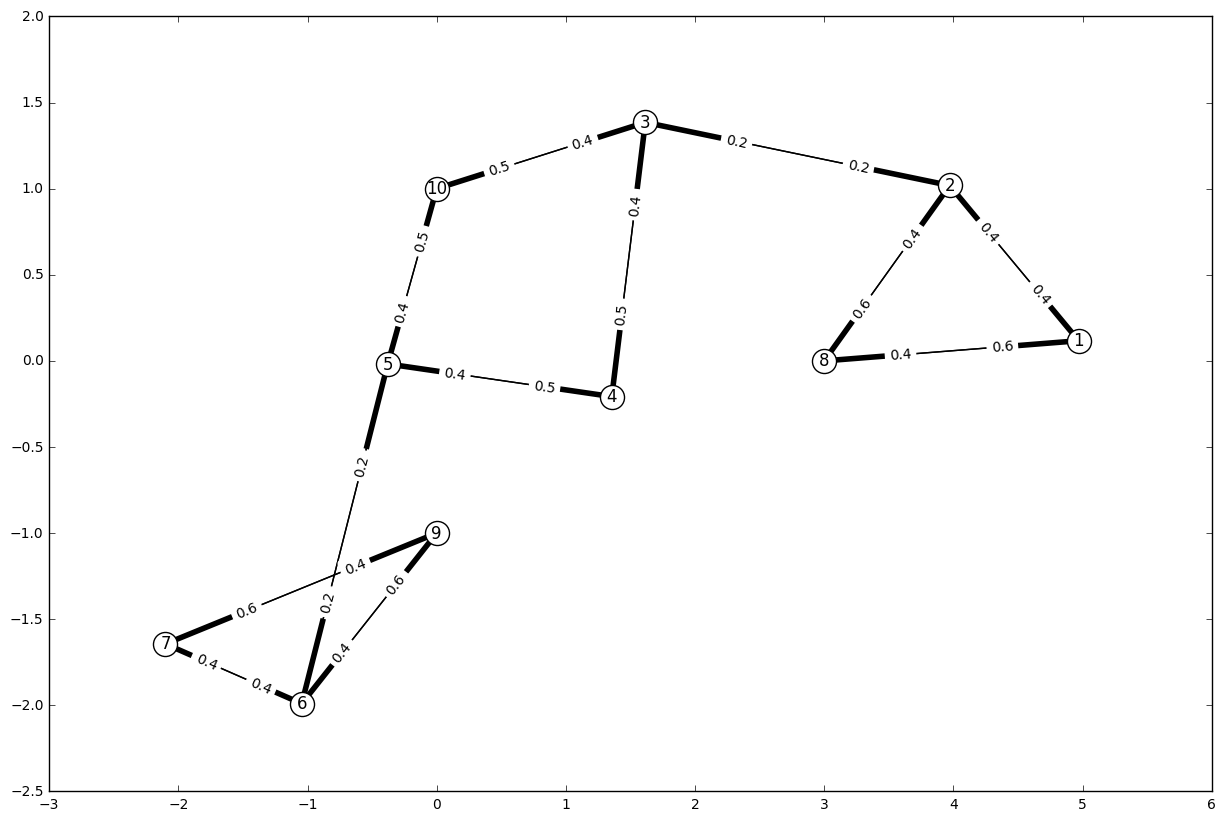

In [16]:
fixed_positions = {8:(3,0),10:(0,1),9:(0,-1)}
fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes)
edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])

plt.figure(1, figsize=(15,10))
nx.draw_networkx_labels(G,pos)
nx.draw_networkx_nodes(G, pos, node_color='w')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,label_pos=0.7)
nx.draw_networkx_edges(G, pos, arrows=True)

Here we define markov chain generator. We basically sample random variables for each row after jump with corresponding $\lambda$. Receiving the row of random variables(transition times) we choose the lowest. Not connected edges receive $\infty$. This is a direct approach to modelling

In [118]:
def markov_walk(m,number=5,length=10,seed=1234):
    shape = m.shape
    rs=RandomState(seed)
    sequence=[]
    times = []
    s = len(m)
    for i in range(number):
        node = rs.choice(range(shape[0]))
        transitions = np.zeros(length)
        walk = np.zeros(length)
        c=0
        while c in range(length):
            t = np.zeros(s)
            for j in range(s):
                if m[node][j] == 0.0:
                    t[j]=np.inf
                else:
                    t[j]=np.random.exponential(1.0/m[node][j])
            node=np.argmin(t)
            walk[c] = node
            transitions[c] = min(t)
            c+=1
        sequence.append(walk)
        times.append(transitions)
    return sequence,times

In [162]:
seq,time = markov_walk(Matr)
print 'Sequence of jumps for CTMC'
print seq[0]
print 'Holding times for nodes'
print time[0]

Sequence of jumps for CTMC
[ 4.  3.  4.  5.  6.  8.  5.  6.  5.  8.]
Holding times for nodes
[ 0.0839283   0.16229065  0.05476951  0.10924164  0.1768501   0.02927377
  0.02461623  0.0692505   0.05852192  0.05455914]


Here we can observe how the nodes change with time

In [19]:
sequence,holding = markov_proc(Q,qi,length = 50,seed=1000)
for i in range(len(holding)):
    holding[i] = holding[i] // 0.001
    holding[i] = np.cumsum(holding[i])


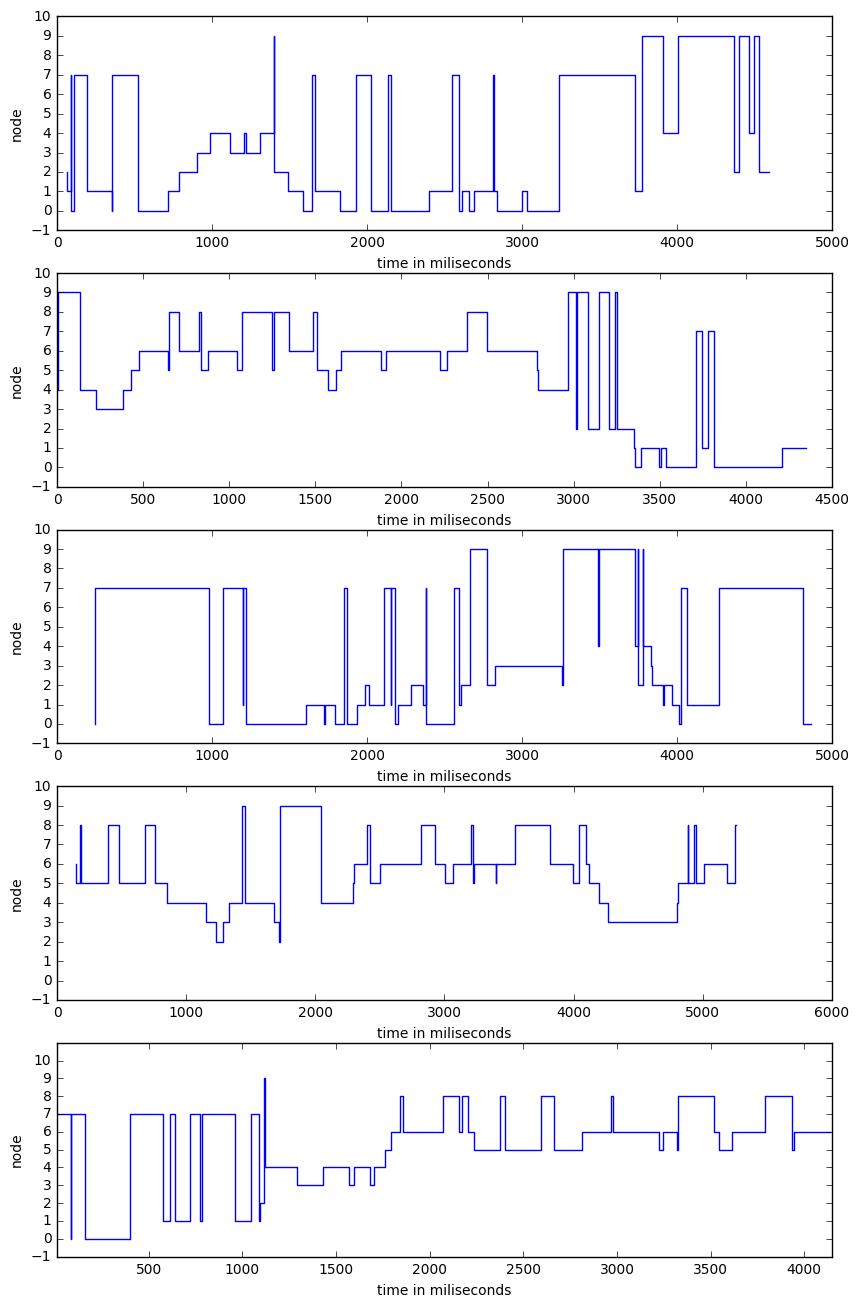

In [20]:
fig, ax = plt.subplots(5,1,figsize=(10,16))
for i in range(5):
    t_min = min(holding[i])+10
    t_max = max(holding[i])+10
    ax[i].set_xlabel('time in miliseconds')
    ax[i].set_ylabel('node')
    x = holding[i]
    y = sequence[i]    
    im = ax[i].step(x, y)
    plt.axis([t_min, t_max , -1, 11])
    ax[i].set_yticks(np.arange(-1,11,1))

Here we count jumps from node i to node j. As we are limited by time, not number of jumps, for each jump with time T it's calculated what node the system is in in time T+t. The we receive array of 'steps to take' for each node to reach node at time T+t. so it can look like $[...i_t+0,i_{t+1}t+2,i_{t+2}+1,...]$ 

In [139]:
def count_mc(processes,time,t,size = 10):
    transition =  np.zeros((size,size))
    walklength = len(processes[0])
    for r in range(len(processes)):
        temp_matrix = np.zeros((size,size))
        lim = next(i-1 for i,v in enumerate(time[r]) if v>=(max(time[r])-t))
        enum = list(enumerate(processes[r][:lim]))
        shift =np.zeros(len(enum))
        for j in range(len(enum)):
            shift[j] = next((i-j-1 for i,v in enumerate(time[r]) if v>=time[r][j]+t),0)
        for num in range(size):
            entrys = np.array([place for place, node in enum if node == num])
            count = float(len(entrys))
            if count == 0:
                pass
            else:
                temp_shift = shift[entrys].astype(int)
                entrys = entrys+temp_shift
                nodes = processes[r][entrys]
                unique, counts = np.unique(nodes, return_counts=True)
                count_trans = dict(zip(unique, counts))
                for i in range(size):
                    try:
                        temp_matrix[num][i] = count_trans[i] / float(count)
                    except KeyError:
                        temp_matrix[num][i] = 0.0
        transition = transition + temp_matrix
    for i in range(size):
        transition[i] = transition[i] / sum(transition[i])
    return transition 

In [24]:
sequence,times = markov_proc(Q,qi,number=2,length=100)
for t in range(len(times)):
    times[t] = np.cumsum(times[t])
print count_mc(sequence,times,0.1,size = 10)

[[ 0.16666667  0.16666667  0.          0.          0.          0.          0.
   0.66666667  0.          0.        ]
 [ 0.25        0.125       0.375       0.          0.          0.          0.
   0.25        0.          0.        ]
 [ 0.0625      0.          0.43269231  0.10096154  0.11538462  0.          0.
   0.0625      0.          0.22596154]
 [ 0.          0.          0.125       0.22916667  0.35416667  0.0625
   0.08333333  0.08333333  0.          0.0625    ]
 [ 0.          0.          0.08333333  0.07083333  0.52916667  0.14166667
   0.02083333  0.          0.02083333  0.13333333]
 [ 0.          0.          0.06666667  0.02777778  0.12222222  0.4
   0.08333333  0.          0.23888889  0.06111111]
 [ 0.          0.          0.          0.          0.02941176  0.14705882
   0.36764706  0.          0.33088235  0.125     ]
 [ 0.16666667  0.          0.16666667  0.          0.          0.          0.
   0.66666667  0.          0.        ]
 [ 0.          0.          0.          0.02

We can see here that conversion is noticeable, yet not perfect. It is partly connected with problems of sampling- for bit t you need extreemly big sample of walks to simulate properly. Still, it bears certain semblance to real stationary distribution

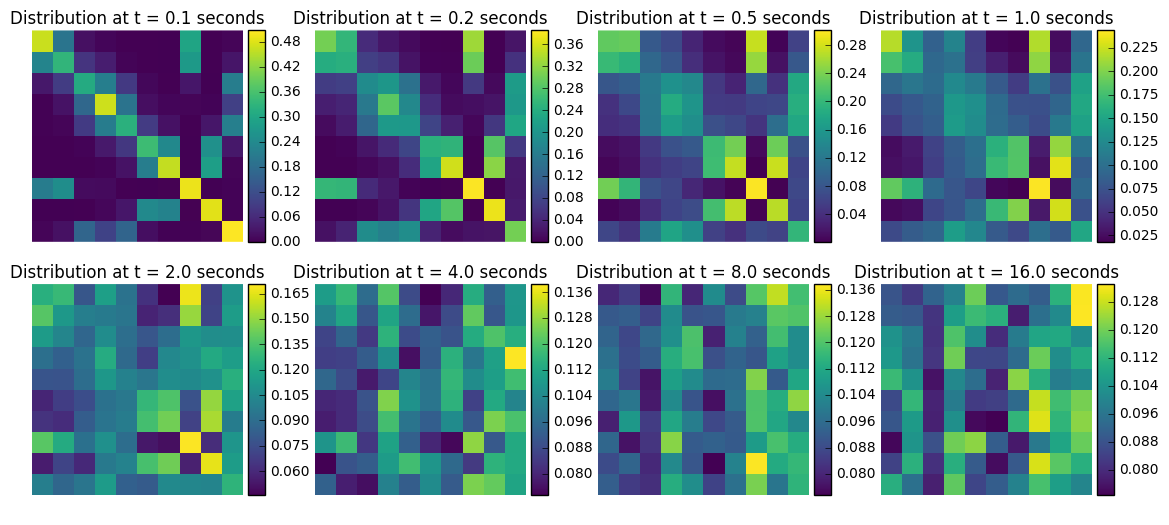

In [123]:
sequence,times = markov_walk(Matr,number=2,length=6000,seed =123)
for t in range(len(times)):
    times[t] = np.cumsum(times[t])

fig, ax = plt.subplots(2,4,figsize=(14,6))
row=[0.1,0.2,0.5,1,2,4,8,16]
for i in range(8):
    A = count_mc(sequence,times,row[i],size = 10)
    vmin = np.amin(A)
    vmax = np.amax(A)
    im = ax[i // 4,i % 4].imshow(A,cmap=plt.cm.viridis, interpolation='None', vmin=vmin, vmax=vmax)
    ax[i // 4,i % 4].set_title('Distribution at t = %.1f seconds'% row[i]) 
    divider = make_axes_locatable(ax[i // 4,i % 4])
    cax = divider.append_axes("right", size="8%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    ax[i // 4,i % 4].axis('off')

As we have stated above, the Continious Time Markov Process can be represented by DTMC and some exponential holding time simulation. As we already know from previous excercises, DTMC has a stable distribution, which can be determined by eigenvalue solution. Below is eigenvalues for DTMC with the same graph and probabilities of transition.

In [28]:
w,v =np.linalg.eig(np.transpose(Q))
w = np.around(w,decimals=5)
num = w.tolist().index(1.0)
eighvec = v[:,num]
eighvec_n =  np.real(eighvec/sum(eighvec))

print eighvec_n

[ 0.08413462  0.11418269  0.11418269  0.09134615  0.11418269  0.11418269
  0.08413462  0.09615385  0.09615385  0.09134615]


This is solution of eigenvector problem for DTMC with the same graph. Continious Markov process stable distribution is connected to one of the discrete, with the folowing equation:
$$\omega_i = \frac{\frac{\Pi_i}{q_i}}{\sum \frac{\Pi_i}{q_i}}$$

In [163]:
print -qi
w = (eighvec_n/qi)/sum(eighvec_n/qi)
print w

[ 10.  15.  15.  10.  15.  15.  10.  10.  10.  10.]
[ 0.09924386  0.08979206  0.08979206  0.10775047  0.08979206  0.08979206
  0.09924386  0.11342155  0.11342155  0.10775047]


In [124]:
W = np.zeros((10,10))
for i in range(10):
    W[i]=w

Here we can observe theoretical distribution visualised

(-0.5, 9.5, 9.5, -0.5)

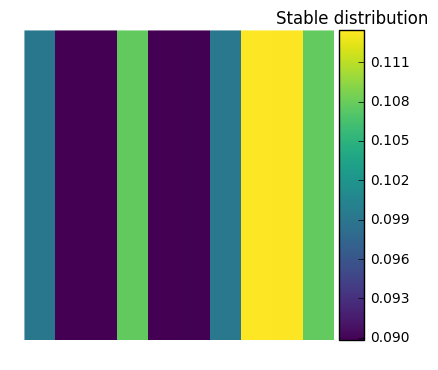

In [39]:
fig =plt.figure(1)
ax = plt.subplot(111)
vmin = np.amin(W)
vmax = np.amax(W)
im = ax.imshow(W,cmap=plt.cm.viridis, interpolation='None', vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.05)
plt.title('Stable distribution') 
cbar = plt.colorbar(im, cax=cax)
ax.axis('off')

Finally, we can calculate convergence to stable distribution:

In [66]:
def RMSE(x,y):
    a = np.reshape(x,-1)
    b = np.reshape(y,-1)
    rmse = np.sqrt(np.mean(map(lambda n, m: (n-m)**2,a,b)))
    return rmse

In [158]:
x_range = np.arange(0.1,10,0.3)
f = np.zeros(len(x_range))
for i in range(len(x_range)):
    sequence,times = markov_walk(Matr,number=2,length=3000,seed =123)
    for t in range(len(times)):
        times[t] = np.cumsum(times[t])
    X = count_mc(sequence,times,x_range[i],size = 10)
    Y = W
    f[i] = RMSE(X,Y)

In [165]:
print f

[ 0.13904784  0.09433184  0.07275447  0.06354869  0.04871225  0.04131158
  0.0313738   0.03060673  0.02292686  0.02361346  0.02045804  0.01378976
  0.01683462  0.01523514  0.02051981  0.01607587  0.01612283  0.02303772
  0.01774598  0.01649688  0.01855502  0.01681041  0.01474694  0.02146786
  0.0268623   0.01475185  0.01773186  0.02177742  0.02203994  0.01427762
  0.01758715  0.0189368   0.01707361]


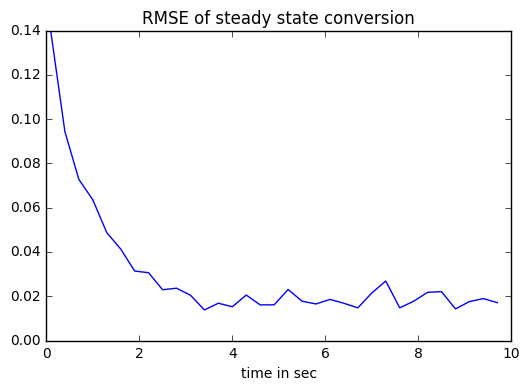

In [160]:
plt.figure(1)
ax = plt.subplot(111)
plt.title('RMSE of steady state conversion')
plt.xlabel('time in sec')
plt.plot(x_range,f)

 ## Unnesessary addition ##

The explanation for choosing the straight approach to modelling CTMC instead of combination of DTMC and holding time simulation is folowing:

The solution was implemented, as you can see below.
However, for some reason it produced the results more in line with DTMC representation of the problem.
As it can be seen from the converging matrices, it closely resembles DTMC solution instead of CTMC.
At each step, node's own $ \lambda $ is used, obtained from qi to simulate time between transitions. However, the simulation fails to correct itself for the different holding times

In [17]:
def markov_proc(m,q,number=5,length=10,seed=1234):
    shape = m.shape
    rs=RandomState(seed)
    sequence=[]
    times = []
    for i in range(number):
        node = rs.choice(range(shape[0]))
        transitions = np.zeros(length)
        walk = np.zeros(length)
        c=0
        while c in range(length):
            node=rs.choice(range(shape[0]),p=m[node])
            walk[c] = int(node)
            transitions[c] = rs.exponential(abs(1.0/q[node]))
            c+=1
        sequence.append(walk)
        times.append(transitions)
    return sequence,times

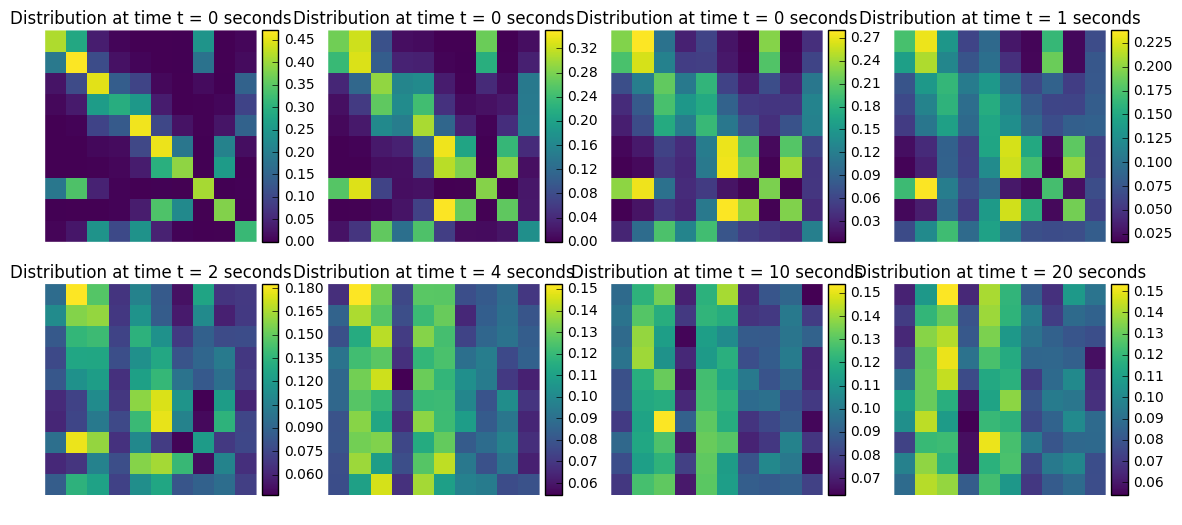

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

sequence,times = markov_proc(Q,qi,number=2,length=6000,seed =123)
for t in range(len(times)):
    times[t] = np.cumsum(times[t])

fig, ax = plt.subplots(2,4,figsize=(14,6))
row=[0.1,0.2,0.5,1,2,4,10,20]
for i in range(8):
    A = count_mc(sequence,times,row[i],size = 10)
    vmin = np.amin(A)
    vmax = np.amax(A)
    im = ax[i // 4,i % 4].imshow(A,cmap=plt.cm.viridis, interpolation='None', vmin=vmin, vmax=vmax)
    ax[i // 4,i % 4].set_title('Distribution at time t = %d seconds'% row[i]) 
    divider = make_axes_locatable(ax[i // 4,i % 4])
    cax = divider.append_axes("right", size="8%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    ax[i // 4,i % 4].axis('off')

